Unsupervised learning - Clustering

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np  
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score
from sklearn.decomposition import PCA

In [47]:
df = pd.read_csv('ddos_dataset.csv', low_memory=False)
X = pd.read_csv('pca_dataframe.csv', low_memory=False).to_numpy()
y = df['label']
n_y = len(y.unique()) #number of different labels

Number of cluster selection: we evaluate the proper number of clusters on the silhouette score in a validation computing the silhouette score for differents number cluster of parameters for each clustering algorithm chosen

Gaussian Mixture

Best number of clusters: 17 with corresponding silhouette score: 0.5195930296541997


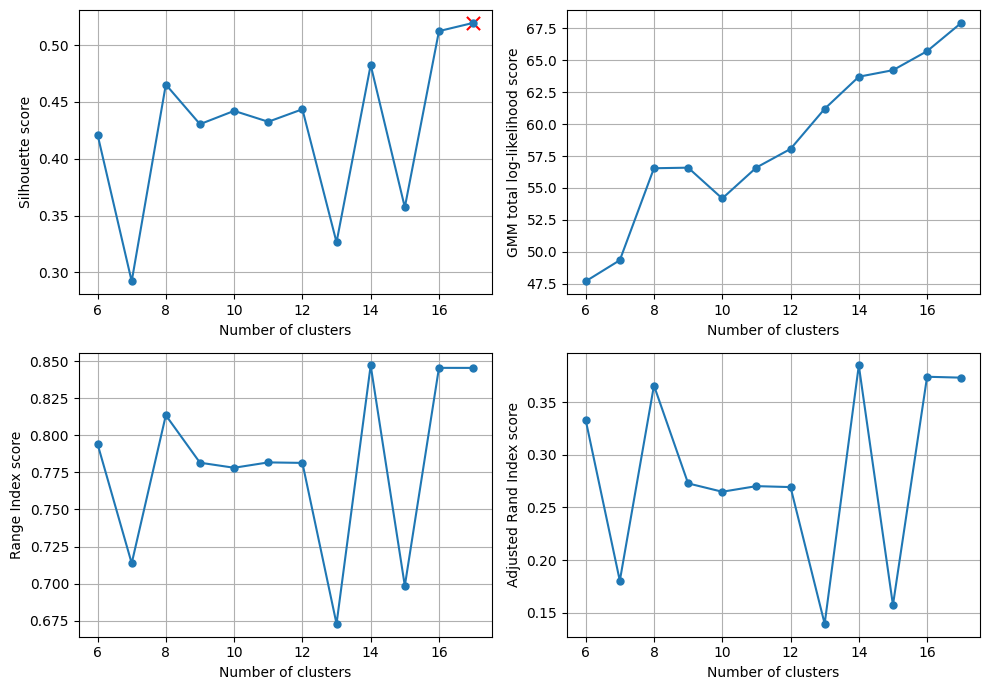

In [4]:
n_cluster = []
sh_scores = []
ri_scores = []
ari_scores = []
log_l_list = []


for n in range(int(n_y / 2), int(1.5 * n_y)):
    gmm = GaussianMixture(n_components=n)
    labels = gmm.fit_predict(X)
    n_cluster.append(n)
    sh_scores.append(silhouette_score(X, labels))
    ri_scores.append(rand_score(np.ravel(y), labels))
    ari_scores.append(adjusted_rand_score(np.ravel(y), labels))
    log_l_list.append(gmm.score(X))

best_sh = np.max(sh_scores)
best_n = n_cluster[np.argmax(sh_scores)]
print(f'Best number of clusters: {best_n} with corresponding silhouette score: {best_sh}')

fig, ax = plt.subplots(2, 2, figsize=(10, 7))

ax[0, 0].plot(n_cluster, sh_scores, marker='o', markersize=5)
ax[0, 0].scatter(best_n, best_sh, color='r', marker='x', s=90)
ax[0, 0].grid()
ax[0, 0].set_xlabel('Number of clusters')
ax[0, 0].set_ylabel('Silhouette score') 

ax[0, 1].plot(n_cluster, log_l_list, marker='o', markersize=5)
ax[0, 1].grid()
ax[0, 1].set_xlabel('Number of clusters')
ax[0, 1].set_ylabel('GMM total log-likelihood score')

ax[1, 0].plot(n_cluster, ri_scores, marker='o', markersize=5)
ax[1, 0].grid()
ax[1, 0].set_xlabel('Number of clusters')
ax[1, 0].set_ylabel('Range Index score')

ax[1, 1].plot(n_cluster, ari_scores, marker='o', markersize=5)
ax[1, 1].grid()
ax[1, 1].set_xlabel('Number of clusters')
ax[1, 1].set_ylabel('Adjusted Rand Index score')

plt.tight_layout()
plt.show()

In [48]:
best_n = 17

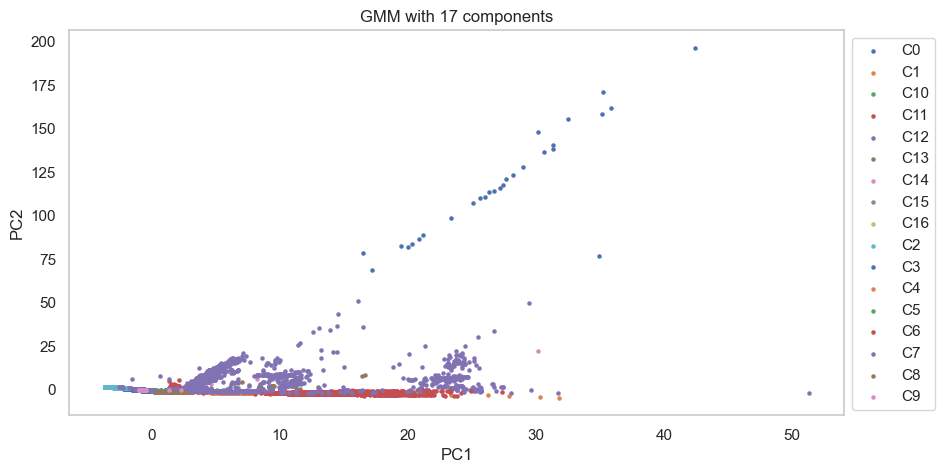

In [49]:
pca_result =pd.read_csv('pca_dataframe.csv').to_numpy()
df = pd.DataFrame(pca_result[:, :2])

gmm = GaussianMixture(n_components=best_n)
labels = gmm.fit_predict(X)
df['cid_gmm'] = [f'C{x}' for x in labels]

fig, ax = plt.subplots(figsize=(10,5))

for i in np.unique(df.cid_gmm):
    subdf = df[df.cid_gmm == i]
    ax.scatter(subdf[0], subdf[1], label=i, s=5)
lgnd = ax.legend(bbox_to_anchor=(1, 1), loc="upper left")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title(f'GMM with {best_n} components')
ax.grid()

In [50]:
cluster_df = df

DBSCAN

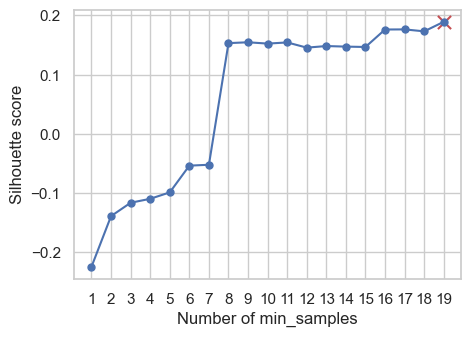

In [53]:
sh_scores = []
n_samples = []

for min in range(1, 20):
    
    dbscan = DBSCAN(min_samples=min)
    labels = dbscan.fit_predict(X)
    sh_scores.append(silhouette_score(pca_result, labels))
    n_samples.append(min)

best_sh = np.max(sh_scores)
best_n = n_samples[np.argmax(sh_scores)]

plt.figure(figsize=(5, 3.5))
plt.plot(n_samples, sh_scores, marker='o', markersize=5)
plt.scatter(best_n, best_sh, color='r', marker='x', s=90)
plt.xlabel('Number of min_samples')
plt.ylabel('Silhouette score') 
plt.xticks(np.arange(1, best_n + 1))
plt.grid(True)
plt.show()


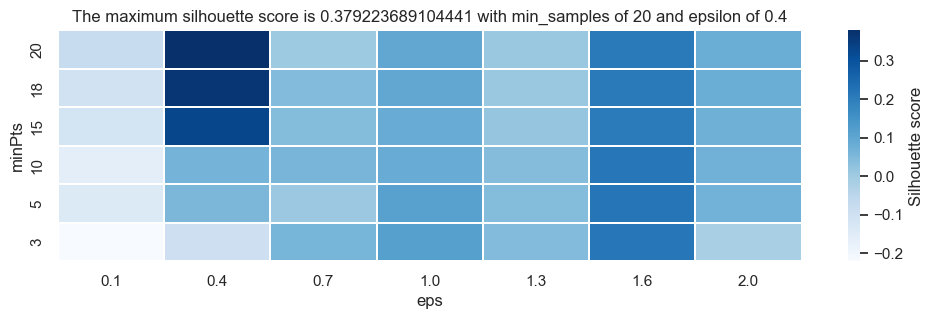

In [65]:
sh_scores =[]
ri_scores = []
ari_scores = []

mins = [3, 5, 10, 15, 18, 20]
epsilon = [0.1, 0.4, 0.7, 1, 1.3, 1.6, 2]

labels = []
for eps in epsilon:
    for min in mins:
        dbscan = DBSCAN(eps=eps, min_samples=min)
        labels = dbscan.fit_predict(X)
        sh_scores.append((eps, min, silhouette_score(X, labels)))
        ri_scores.append((eps, mins, rand_score(np.ravel(y), labels)))
        ari_scores.append((eps, mins, adjusted_rand_score(np.ravel(y), labels)))

gs = pd.DataFrame(sh_scores, columns=['eps', 'minPts', 'sh'])
gs = pd.pivot_table(gs, columns='eps', index='minPts', values='sh', aggfunc=lambda x:x)

plt.figure(figsize=(12,3))
max_ss = gs.max().max()
mins_max_ss = gs.stack().idxmax()[0]
eps_max_ss = gs.stack().idxmax()[1]
plt.title(f'The maximum silhouette score is {max_ss} with min_samples of {mins_max_ss} and epsilon of {eps_max_ss}')
sns.heatmap(gs, cmap='Blues', cbar_kws={'label':'Silhouette score'}, linewidths=.005)
plt.gca().invert_yaxis()
plt.show()

Text(0.5, 1.0, 'DBSCAN with eps = 0.4 and min_samples = 20')

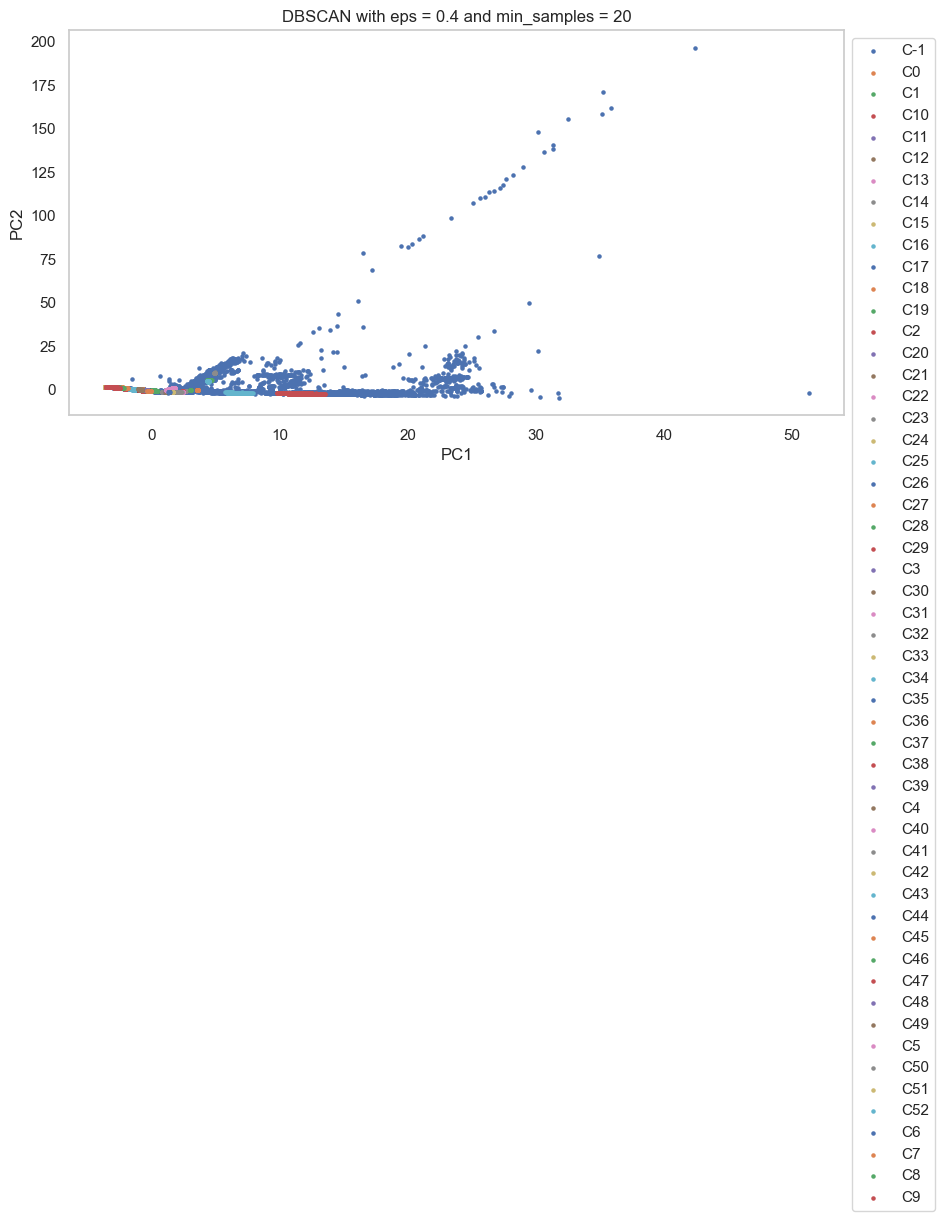

In [68]:
n_samples, n_features = df.shape
labels = []
dbscan = DBSCAN(eps=eps_max_ss, min_samples=mins_max_ss)
labels = dbscan.fit_predict(X)


df = pd.DataFrame(df)
df['cid_dbscan'] = [f'C{x}' for x in labels]

fig, ax = plt.subplots(figsize=(10,5))

for i in np.unique(df.cid_dbscan):
    subdf = df[df.cid_dbscan == i]
    ax.scatter(subdf[0], subdf[1], label=i, s=5)
plt.grid()
lgnd = ax.legend(bbox_to_anchor=(1, 1), loc="upper left")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title(f'DBSCAN with eps = {eps_max_ss} and min_samples = {mins_max_ss}')



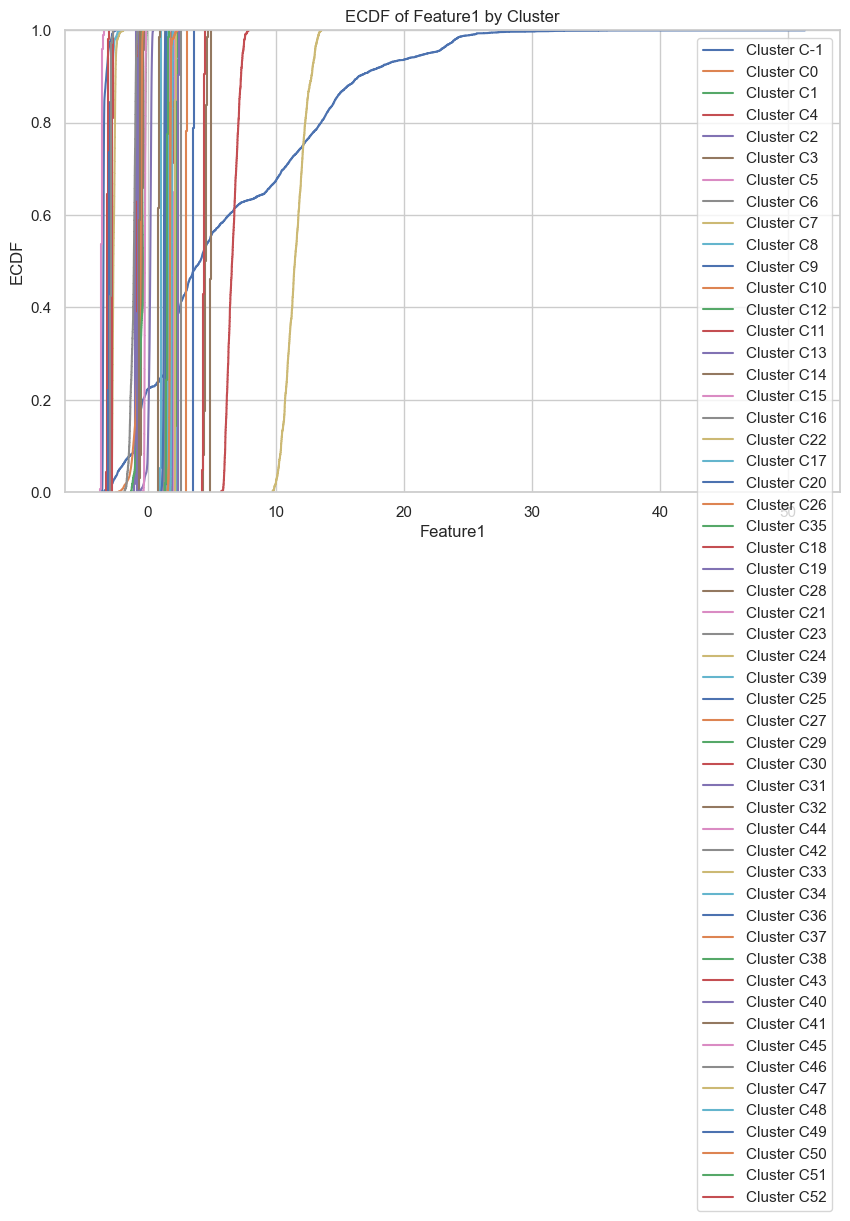

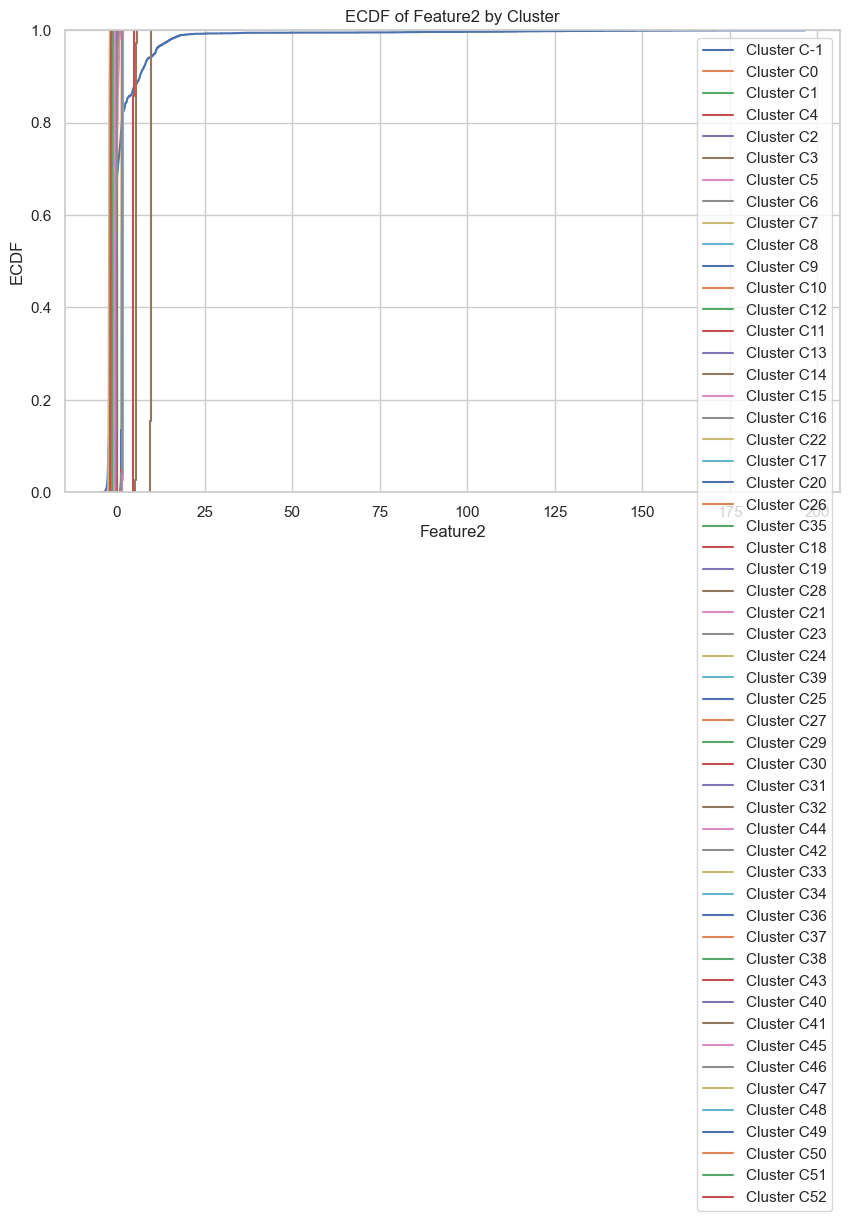

In [85]:
data = pd.DataFrame({
    'Feature1': cluster_df[0],
    'Feature2': cluster_df[1],
    'Cluster': cluster_df['cid_dbscan']
})

# Plot ECDFs for each feature within each cluster
for feature in ['Feature1', 'Feature2']:
    plt.figure(figsize=(10, 6))
    for cluster in data['Cluster'].unique():
        subset = data[data['Cluster'] == cluster]
        ecdf = sns.ecdfplot(subset[feature], label=f'Cluster {cluster}')

    plt.title(f'ECDF of {feature} by Cluster')
    plt.xlabel(feature)
    plt.ylabel('ECDF')
    plt.legend()
    plt.show()

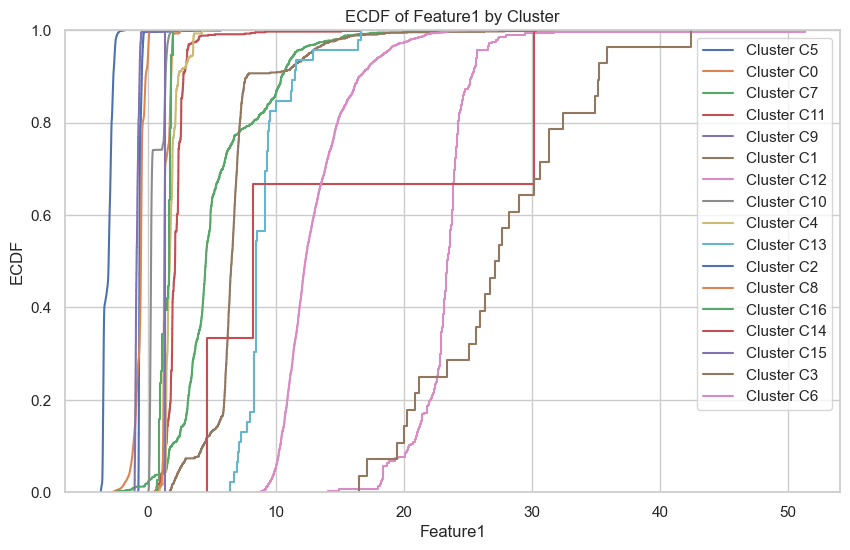

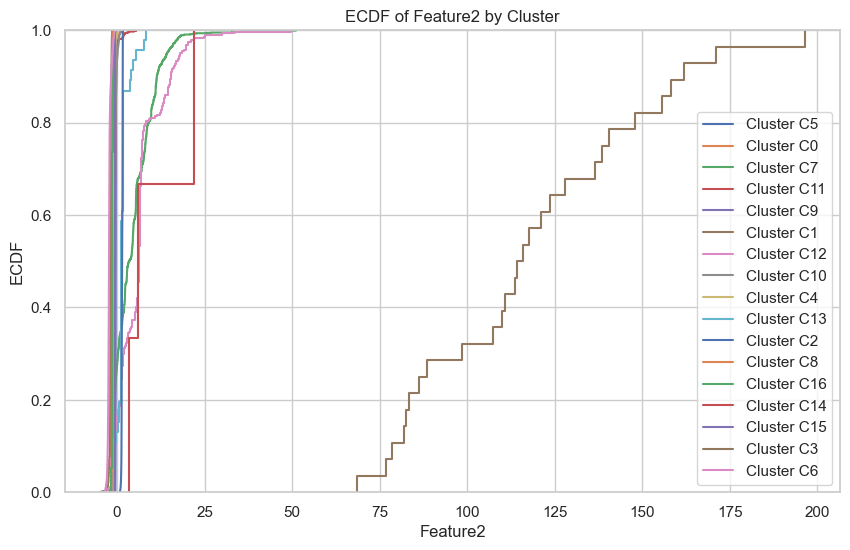

In [86]:
data = pd.DataFrame({
    'Feature1': cluster_df[0],
    'Feature2': cluster_df[1],
    'Cluster': cluster_df['cid_gmm']
})

# Plot ECDFs for each feature within each cluster
for feature in ['Feature1', 'Feature2']:
    plt.figure(figsize=(10, 6))
    for cluster in data['Cluster'].unique():
        subset = data[data['Cluster'] == cluster]
        ecdf = sns.ecdfplot(subset[feature], label=f'Cluster {cluster}')

    plt.title(f'ECDF of {feature} by Cluster')
    plt.xlabel(feature)
    plt.ylabel('ECDF')
    plt.legend()
    plt.show()

In [17]:
cluster_df[2] = X[:,2]


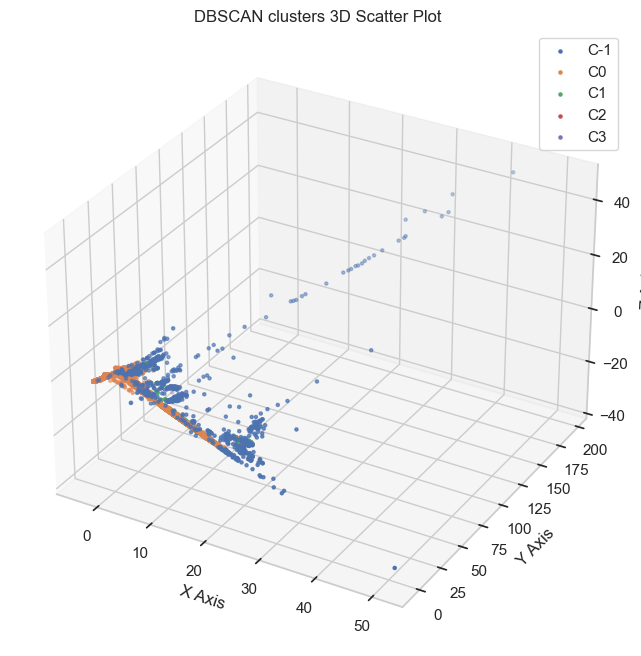

In [18]:
sns.set(style="whitegrid")
# Create a 3D scatter plot with color-coded clusters using Seaborn
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for i in np.unique(cluster_df.cid_dbscan):
    subdf = cluster_df[cluster_df.cid_dbscan == i]
    ax.scatter(subdf[0], subdf[1], subdf[2], label=i, s=5)

# Customize the plot
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('DBSCAN clusters 3D Scatter Plot')
ax.legend()

# Show the plot
plt.show()

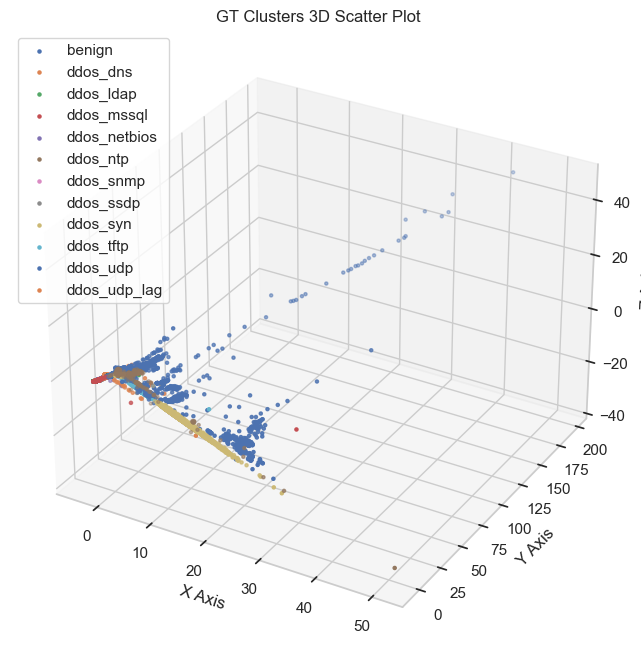

In [19]:
sns.set(style="whitegrid")
# Create a 3D scatter plot with color-coded clusters using Seaborn
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for i in np.unique(cluster_df.label):
    subdf = cluster_df[cluster_df.label == i]
    ax.scatter(subdf[0], subdf[1], subdf[2], label=i, s=5)

# Customize the plot
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('GT Clusters 3D Scatter Plot')
ax.legend()

# Show the plot
plt.show()